**Main Code of Explainable GRU-based IDS**

Selected Features: ['IAT', 'ICMP', 'syn_flag_number', 'TCP', 'UDP', 'psh_flag_number', 'syn_count', 'fin_flag_number', 'Protocol Type', 'flow_duration', 'ack_flag_number', 'rst_flag_number', 'Magnitue', 'Header_Length', 'Variance']


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 256)            │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 34)             │         8,738 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,674 (815.13 KB)

 Trainable params: 208,162 (813.13 KB)

 Non-trainable params: 512 (2.00 KB)

Profiler error: start() missing 1 required positional argument: 'logdir'
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


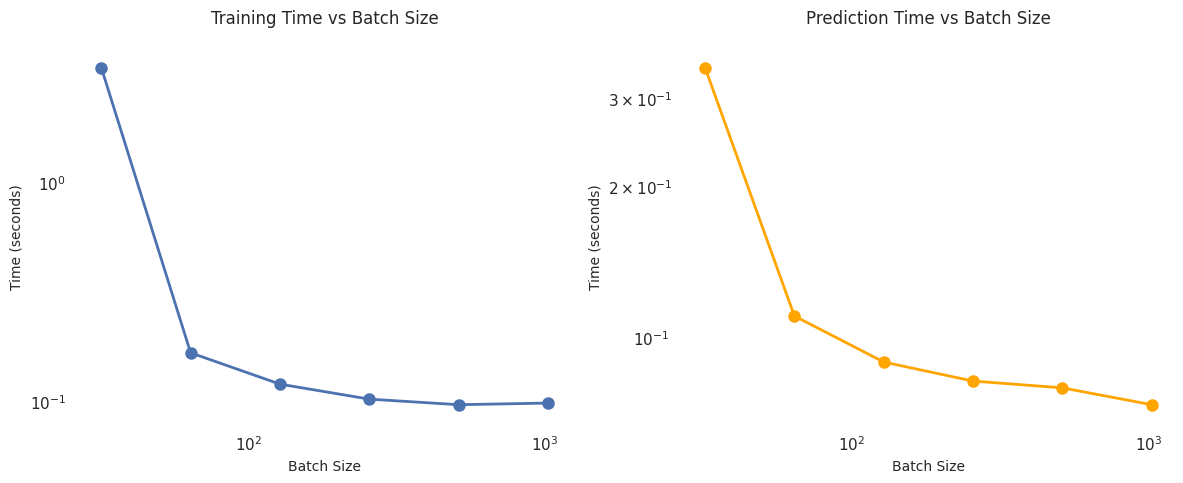

Epoch 1/120
829/833 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6396 - loss: 1.0233
Epoch 1: val_accuracy improved from -inf to 0.72908, saving model to /content/drive/MyDrive/IoT2023_Dataset/Train_GRU2.keras
833/833 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.6400 - loss: 1.0219 - val_accuracy: 0.7291 - val_loss: 0.6685 - learning_rate: 0.0010
Epoch 2/120
829/833 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7508 - loss: 0.6097
Epoch 2: val_accuracy did not improve from 0.72908
833/833 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7508 - loss: 0.6096 - val_accuracy: 0.7055 - val_loss: 0.6386 - learning_rate: 0.0010
Epoch 3/120
833/833 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7702 - loss: 0.5550
Epoch 3: val_accuracy did not improve from 0.72908
833/833 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7702 - loss: 0.5549 - val_accuracy: 0.7243 - val_loss: 0.5981 - learning_rate: 0.0010
Epoch 4/120
833/833 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7838 - loss:

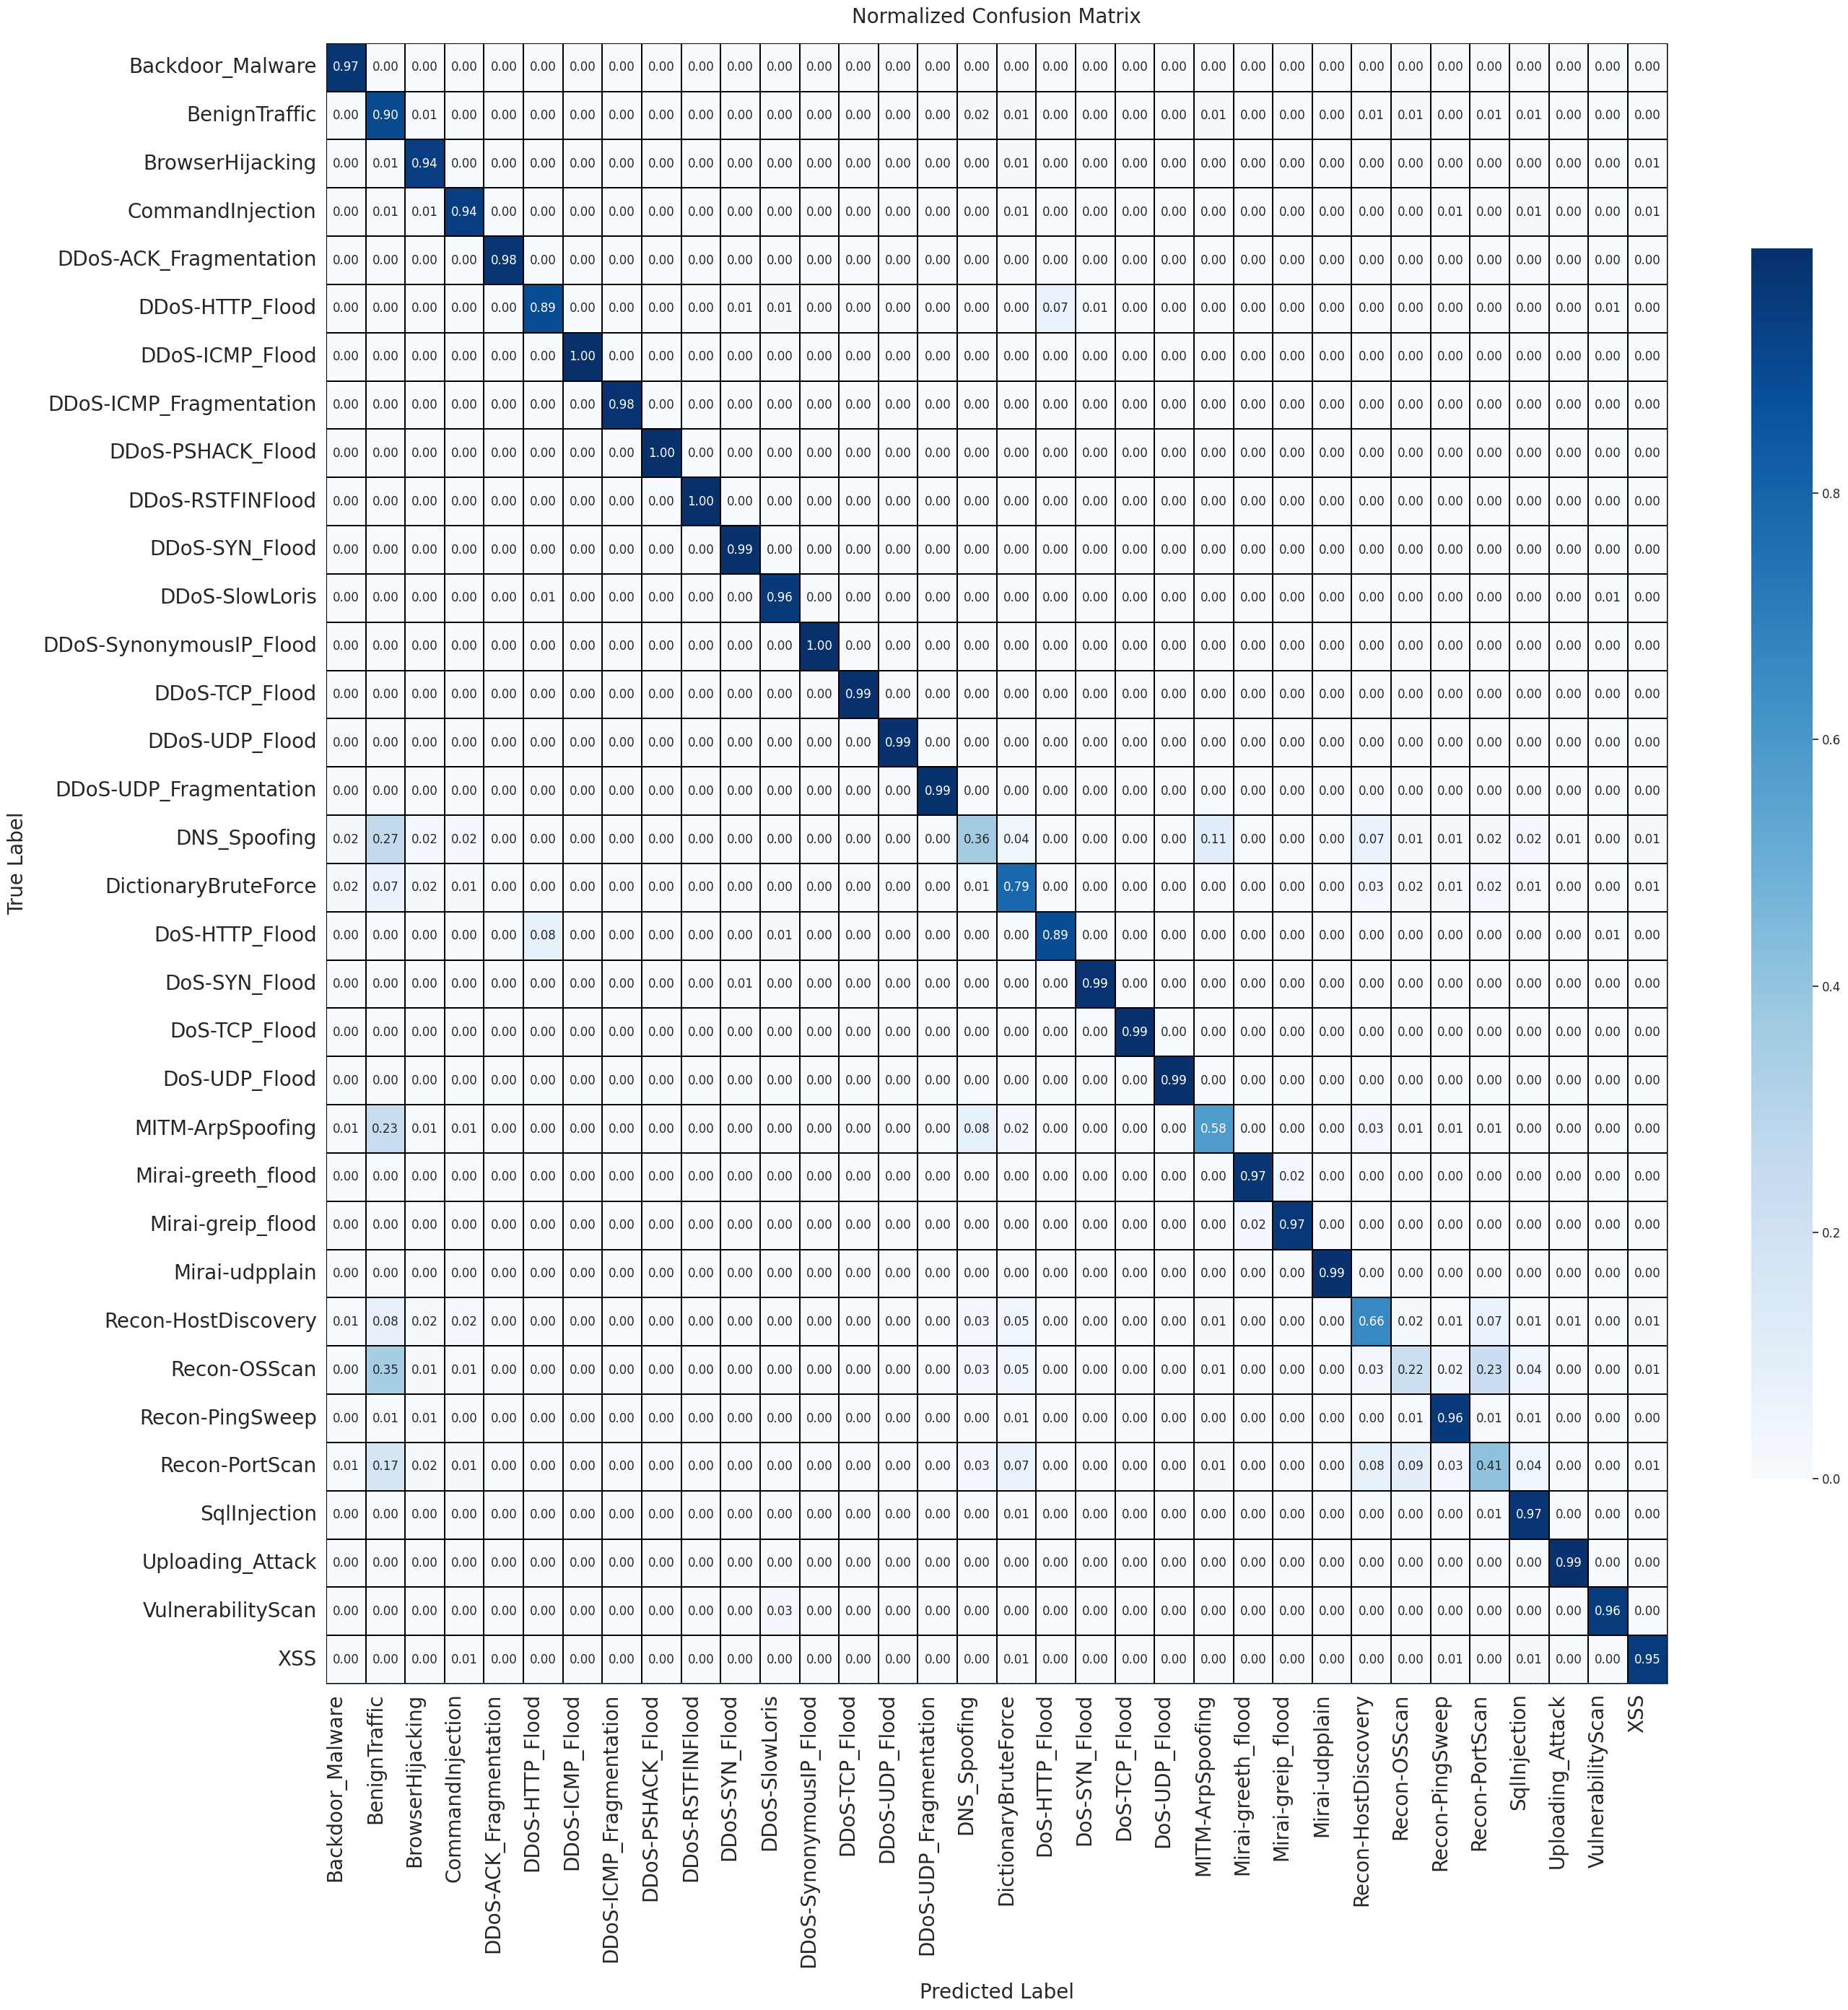

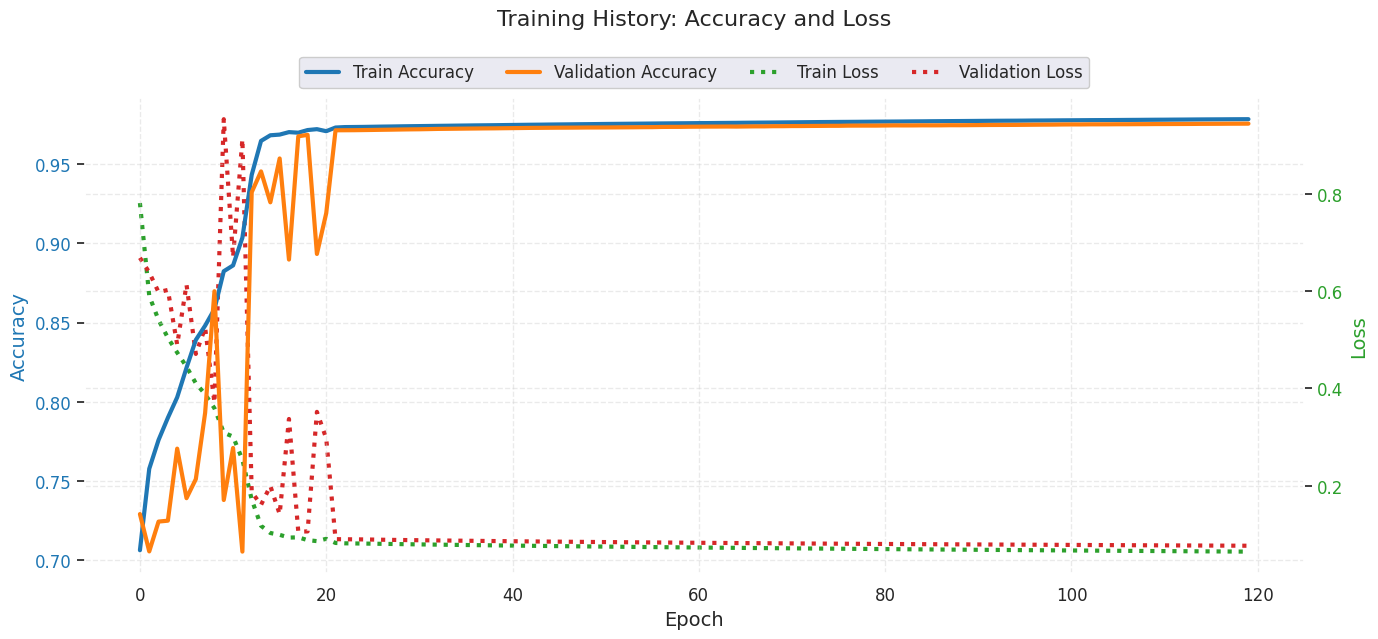

In [ ]:
# =============================================
# Import Libraries
# =============================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, cohen_kappa_score, confusion_matrix,
                            classification_report)
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import GRU, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
import warnings
import shap
from shap.plots import colors
from shap.utils import safe_isinstance, OpChain, format_value
import time
import psutil
import os
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
import networkx as nx
from collections import defaultdict
import matplotlib.colors as mcolors

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set seaborn to default settings
sns.set()

# Ignore warnings
warnings.filterwarnings("ignore")

# Initialize SHAP JS for visualization in notebooks
shap.initjs()

# =============================================
# Data Loading and Sampling
# =============================================
def load_and_prepare_data(filepath, sample_size=1000000):
    """Load dataset and perform initial sampling."""
    df = pd.read_csv(filepath, low_memory=False)
    df = df.sample(n=sample_size, random_state=42)
    return df

# Load dataset
dataset_path = '/content/drive/MyDrive/IoT2023_Dataset/Combined_IoT2023.csv'
df = load_and_prepare_data(dataset_path)

# =============================================
# Data Preprocessing
# =============================================
# Separate features and target
X = df.drop(['label'], axis=1)
Y = df['label']

# Define SMOTE sampling strategy
smote_strategy = {
    'DNS_Spoofing': 5000, 'Recon-HostDiscovery': 5000,
    'Recon-OSScan': 5000, 'Recon-PortScan': 5000,
    'DoS-HTTP_Flood': 5000, 'VulnerabilityScan': 5000,
    'DDoS-HTTP_Flood': 5000, 'DDoS-SlowLoris': 5000,
    'DictionaryBruteForce': 5000, 'BrowserHijacking': 5000,
    'SqlInjection': 5000, 'CommandInjection': 5000,
    'XSS': 5000, 'Backdoor_Malware': 5000,
    'Recon-PingSweep': 5000, 'Uploading_Attack': 5000
}

# Apply SMOTE for class balancing
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y_resampled)
class_names = label_encoder.classes_

# =============================================
# Feature Selection
# =============================================
def select_features(X, y, n_features=15):
    """Select top features using Extra Trees Classifier."""
    forest = ExtraTreesClassifier(random_state=42)
    forest.fit(X, y)
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    selected_features = indices[:n_features]
    return selected_features

# Select top 15 features
selected_features = select_features(X_scaled, y_encoded)
selected_feature_names = [X.columns[i] for i in selected_features]
print("Selected Features:", selected_feature_names)

# Use all features (comment out to use only selected features)
# X_selected = X_scaled[:, selected_features]
X_selected = X_scaled

# Convert to one-hot encoding
y_one_hot = to_categorical(y_encoded)

# =============================================
# Train-Test Split
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_one_hot,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# Reshape data for GRU (adding timestep dimension)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# =============================================
# Model Definition
# =============================================
def create_gru_model(input_shape, n_classes):
    """Create GRU model architecture."""
    model = Sequential([
        GRU(256, input_shape=input_shape, return_sequences=False),
        BatchNormalization(),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Re-create the model with the updated function
model = create_gru_model((X_train.shape[1], 1), y_one_hot.shape[1])

# =============================================
# Computational Complexity Analysis
# =============================================
def analyze_computational_complexity(model, X_train, X_test):
    """Analyze and visualize computational complexity of the model."""
    # Model summary
    model.summary()

    # Calculate FLOPs
    try:
        from tensorflow.python.profiler import profiler_v2 as profiler
        profiler.start()
        model.predict(X_train[:1])  # Warm-up
        profiler.stop()

        options = tf.profiler.experimental.ProfilerOptions(
            host_tracer_level=2,
            python_tracer_level=1,
            device_tracer_level=1
        )
        log_dir = './logs'
        tf.profiler.experimental.start(log_dir, options)
        model.predict(X_train[:100])
        tf.profiler.experimental.stop()
    except Exception as e:
        print(f"Profiler error: {e}")

    # Time complexity analysis
    batch_sizes = [32, 64, 128, 256, 512, 1024]
    train_times = []
    predict_times = []

    for batch_size in batch_sizes:
        start_time = time.time()
        model.fit(X_train[:1000], y_train[:1000],
                 epochs=1, batch_size=batch_size, verbose=0)
        train_times.append(time.time() - start_time)

        start_time = time.time()
        model.predict(X_test[:1000], batch_size=batch_size)
        predict_times.append(time.time() - start_time)

    # Plot time complexity with enhanced visualization
    plt.figure(figsize=(12, 5), facecolor='white')

    plt.subplot(1, 2, 1)
    plt.plot(batch_sizes, train_times, marker='o', linewidth=2, markersize=8)
    plt.title('Training Time vs Batch Size', pad=20, fontsize=12)
    plt.xlabel('Batch Size', fontsize=10)
    plt.ylabel('Time (seconds)', fontsize=10)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.gca().set_facecolor('white')

    plt.subplot(1, 2, 2)
    plt.plot(batch_sizes, predict_times, marker='o', color='orange', linewidth=2, markersize=8)
    plt.title('Prediction Time vs Batch Size', pad=20, fontsize=12)
    plt.xlabel('Batch Size', fontsize=10)
    plt.ylabel('Time (seconds)', fontsize=10)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.gca().set_facecolor('white')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/IoT2023_Dataset/IoT2023 XGRU Results/Comp_complexity.png', dpi=1200, bbox_inches='tight')
    plt.show()

# Run computational complexity analysis
analyze_computational_complexity(model, X_train, X_test)

# =============================================
# Model Training with Timing
# =============================================
# Use the new Keras format (.keras) instead of HDF5 (.h5)
model_path = '/content/drive/MyDrive/IoT2023_Dataset/Train_GRU2.keras'

callbacks = [
    callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1
    )
]

# Track training time
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=120,
    batch_size=1024,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)
training_time = time.time() - start_time
print(f"\nTotal Training Time: {training_time:.2f} seconds")

# =============================================
# Model Evaluation
# =============================================
# Load best model
model = tf.keras.models.load_model(model_path)

# Make predictions
start_time = time.time()
y_pred = np.argmax(model.predict(X_test), axis=-1)
prediction_time = time.time() - start_time
y_true = np.argmax(y_test, axis=1)

print(f"\nPrediction Time for {len(X_test)} samples: {prediction_time:.4f} seconds")
print(f"Prediction Time per sample: {prediction_time/len(X_test):.6f} seconds")

# Calculate metrics
metrics = {
    'Accuracy': accuracy_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred, average='weighted'),
    'Recall': recall_score(y_true, y_pred, average='weighted'),
    'F1 Score': f1_score(y_true, y_pred, average='weighted'),
    'Cohen Kappa': cohen_kappa_score(y_true, y_pred)
}

# Print metrics
print("\nModel Evaluation Metrics:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


# Enhanced Confusion Matrix with Custom Styling
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, figsize=(28, 28)):
    """Plot normalized confusion matrix with custom styling."""
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)

    # Create heatmap with custom styling
    ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=classes, yticklabels=classes,
                    linewidths=0.3, linecolor='black',  # Add cell borders
                    cbar_kws={'shrink': 0.75})  # Smaller colorbar

    # Customize axis labels and ticks
    ax.set_xticklabels(ax.get_xticklabels(),
                      rotation=90,
                      ha='right',
                      fontsize=20)  # Increased x-axis font size
    ax.set_yticklabels(ax.get_yticklabels(),
                      rotation=0,
                      fontsize=20)  # Increased y-axis font size

    # Add dotted borders to each cell
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)
        spine.set_linestyle(':')  # Dotted style

    # Customize title and axis labels with larger fonts
    plt.title('Normalized Confusion Matrix', fontsize=20, pad=20)
    plt.ylabel('True Label', fontsize=20, labelpad=15)
    plt.xlabel('Predicted Label', fontsize=20, labelpad=15)

    # Adjust colorbar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/IoT2023_Dataset/IoT2023 XGRU Results/Confusion_matrix.png', dpi=1200, bbox_inches='tight', facecolor='white')
    plt.show()

plot_confusion_matrix(y_true, y_pred, class_names)

# =============================================
# Training History Visualization - Dual Axis (Auto-Scaled with Top Legend)
# =============================================
def plot_training_history(history):
    """Plot training and validation accuracy/loss curves with top legend."""
    # Set global font settings
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'grid.color': '0.8',
        'grid.linestyle': '--',
        'grid.alpha': 0.6
    })

    fig, ax1 = plt.subplots(figsize=(14, 7), facecolor='white')

    # Calculate data ranges with 5% padding
    acc_data = history.history['accuracy'] + history.history['val_accuracy']
    loss_data = history.history['loss'] + history.history['val_loss']

    acc_min, acc_max = min(acc_data), max(acc_data)
    loss_min, loss_max = min(loss_data), max(loss_data)

    acc_range = acc_max - acc_min
    loss_range = loss_max - loss_min

    # Plot Accuracy (left axis)
    color1, color2 = '#1f77b4', '#ff7f0e'  # Blue and orange
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy', color=color1)
    acc_train = ax1.plot(history.history['accuracy'],
                        linewidth=3,
                        label='Train Accuracy',
                        color=color1,
                        linestyle='-')[0]
    acc_val = ax1.plot(history.history['val_accuracy'],
                      linewidth=3,
                      label='Validation Accuracy',
                      color=color2,
                      linestyle='-')[0]
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_ylim(max(0, acc_min - acc_range*0.05),
                min(1, acc_max + acc_range*0.05))
    ax1.grid(True, which='both', alpha=0.4)

    # Plot Loss (right axis)
    ax2 = ax1.twinx()
    color3, color4 = '#2ca02c', '#d62728'  # Green and red
    ax2.set_ylabel('Loss', color=color3)
    loss_train = ax2.plot(history.history['loss'],
                         linewidth=3,
                         label='Train Loss',
                         color=color3,
                         linestyle=':')[0]
    loss_val = ax2.plot(history.history['val_loss'],
                       linewidth=3,
                       label='Validation Loss',
                       color=color4,
                       linestyle=':')[0]
    ax2.tick_params(axis='y', labelcolor=color3)
    ax2.set_ylim(max(0, loss_min - loss_range*0.05),
                loss_max + loss_range*0.05)
    ax2.grid(True, which='both', alpha=0.4)

    # Create unified legend at top
    lines = [acc_train, acc_val, loss_train, loss_val]
    labels = [line.get_label() for line in lines]
    legend = ax1.legend(lines, labels,
                       loc='lower center',
                       bbox_to_anchor=(0.5, 1.02),
                       ncol=4,
                       framealpha=1,
                       borderaxespad=0.)

    # Adjust title position
    plt.title('Training History: Accuracy and Loss',
             pad=35, y=1.05)  # Increased pad and y-position

    # Final layout adjustments
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Make space for top legend
    ax1.set_zorder(ax2.get_zorder()+1)
    ax1.patch.set_visible(False)

    plt.savefig('/content/drive/MyDrive/IoT2023_Dataset/IoT2023 XGRU Results/Train_Test_curves.png',
               dpi=1200,
               bbox_inches='tight',
               facecolor='white')
    plt.show()

plot_training_history(history)


## **Explainability Analysis**

**SHAP Analysis**

In [ ]:
# =============================================
# Explainability Analysis with SHAP - Overall Model Performance (Average Outcomes)
# =============================================

# Define a professional color palette
professional_palette = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
    '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5'
]

# Wrapper function for the GRU model
def gru_predict_wrapper(X):
    """Wrapper function to reshape input for GRU model prediction."""
    X_reshaped = X.reshape((X.shape[0], X_train.shape[1], 1))
    return model.predict(X_reshaped)

# Prepare background data
background_data = X_train[:100].reshape(100, X_train.shape[1])

# Create SHAP explainer
explainer = shap.KernelExplainer(gru_predict_wrapper, background_data)

# Calculate SHAP values for test data subset
shap_subset_size = min(100, len(X_test))  # Ensure we don't exceed available test samples
X_test_subset = X_test[:shap_subset_size].reshape(shap_subset_size, X_test.shape[1])
shap_values = explainer.shap_values(X_test_subset)

# Get feature names
feature_names = X.columns.tolist()

# Get predictions for the subset used for SHAP
y_pred_subset = np.argmax(model.predict(X_test_subset.reshape(X_test_subset.shape[0], X_test_subset.shape[1], 1)), axis=-1)

# Get the true class names for the subset for plotting titles
y_true_subset_encoded = np.argmax(y_test[:shap_subset_size], axis=1)
y_true_names = label_encoder.inverse_transform(y_true_subset_encoded)
y_pred_names = label_encoder.inverse_transform(y_pred_subset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6613/6613 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━

**1. Global Feature Importance (Overall Model Average)**

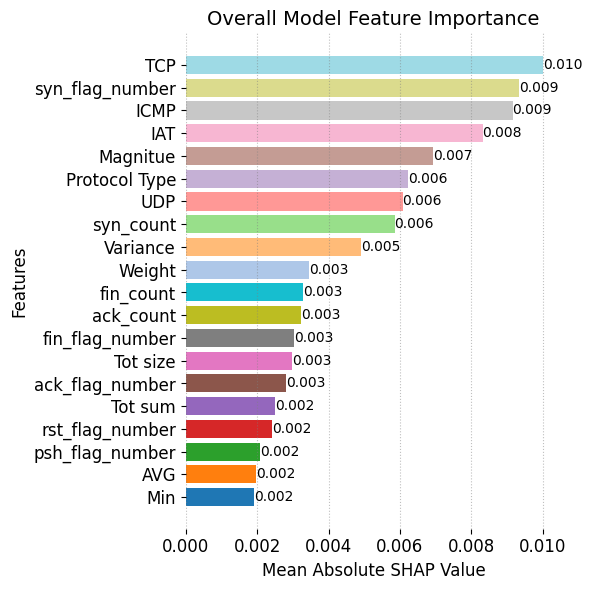

In [ ]:
# 1. Global Feature Importance (Overall Model Average)
plt.figure(figsize=(6, 6))
plt.style.use('default')  # Reset to default style
plt.rcParams['axes.facecolor'] = 'white'  # Set background to white
plt.rcParams['figure.facecolor'] = 'white'  # Set figure background to white

# Set font sizes
title_fontsize = 14
label_fontsize = 12
tick_fontsize = 12
value_label_fontsize = 10  # Font size for value labels

if isinstance(shap_values, list):
    # Multi-class case
    all_class_shap_values = np.array(shap_values)
    mean_abs_shap = np.mean(np.abs(all_class_shap_values), axis=(0, 1))
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # Multi-class case: 3D array
    mean_abs_shap = np.mean(np.abs(shap_values), axis=(0, 2))
else:
    # Binary case
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# Sort features by importance
sorted_idx = np.argsort(mean_abs_shap)[::-1][:20]
sorted_features = np.array(feature_names)[sorted_idx]
sorted_values = mean_abs_shap[sorted_idx]

# Create horizontal bar plot with varied colors
bars = plt.barh(range(len(sorted_idx)), sorted_values[::-1],
         color=professional_palette[:len(sorted_idx)])

# Add value labels in front of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width,  # Position text slightly right of the bar
             bar.get_y() + bar.get_height()/2,  # Center vertically
             f'{width:.3f}',  # Format to 3 decimal places
             va='center',  # Vertical alignment
             ha='left',    # Horizontal alignment
             color='black',
             fontsize=value_label_fontsize,
             fontweight='normal')

plt.yticks(range(len(sorted_idx)), sorted_features[::-1], fontsize=tick_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.xlabel('Mean Absolute SHAP Value', fontsize=label_fontsize)
plt.ylabel('Features', fontsize=label_fontsize)
plt.title('Overall Model Feature Importance', fontsize=title_fontsize)

# Remove spines (borders)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Add grid lines
plt.grid(axis='x', color='gray', linestyle=':', alpha=0.5)
plt.gca().set_facecolor('white')

# Adjust right margin to make room for value labels
plt.subplots_adjust(right=0.85)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/IoT2023_Dataset/IoT2023 XGRU Results/GFI_overall.png', dpi=1200, bbox_inches='tight')
plt.show()

**2. SHAP Summary Plot (Overall Model Average Impact)**

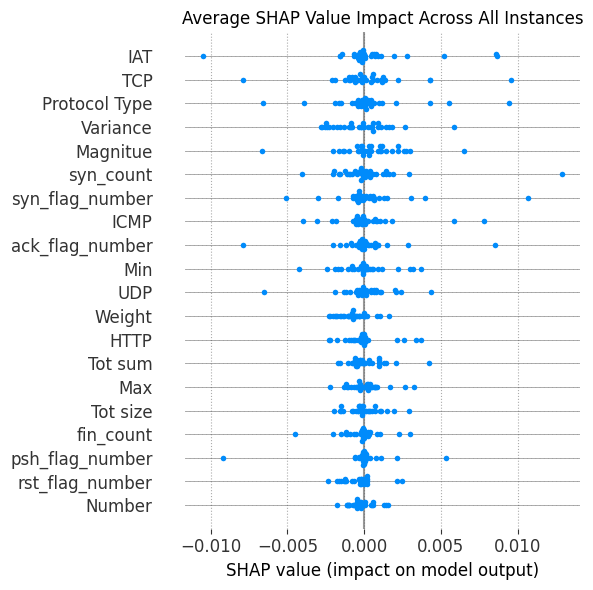

In [ ]:
# 2. SHAP Summary Plot (Overall Model Average Impact)
plt.figure(figsize=(6, 6))
plt.style.use('default')  # Reset to default style
plt.rcParams['axes.facecolor'] = 'white'  # Set background to white
plt.rcParams['figure.facecolor'] = 'white'  # Set figure background to white

# Set font sizes
title_fontsize = 12
label_fontsize = 12
tick_fontsize = 12

# Create SHAP plot with modified font sizes
if isinstance(shap_values, list):
    mean_shap_per_class = np.array([np.mean(sv, axis=0) for sv in shap_values])
    stacked_shap = np.vstack([mean_shap_per_class])
    shap.summary_plot(
        stacked_shap,
        feature_names=feature_names,
        class_names=class_names.tolist(),
        show=False,
        plot_type="dot",
        plot_size=(6, 6)
    )
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    mean_shap = np.mean(shap_values, axis=0)
    mean_shap = mean_shap.T
    shap.summary_plot(
        mean_shap,
        feature_names=feature_names,
        class_names=class_names.tolist(),
        show=False,
        plot_type="dot",
        plot_size=(6, 6)
    )
else:  # Binary case
    mean_shap = np.mean(shap_values, axis=0)
    shap.summary_plot(
        mean_shap.reshape(1, -1),
        feature_names=feature_names,
        show=False,
        plot_type="dot",
        plot_size=(6, 6)
    )

# Apply font size adjustments
plt.title("Average SHAP Value Impact Across All Instances", fontsize=title_fontsize)
plt.gca().set_facecolor('white')

# Adjust font sizes for axes
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# For x-axis label (might need to adjust depending on SHAP version)
for item in ([ax.xaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(tick_fontsize)

# Custom grid settings - darker horizontal lines
ax.grid(axis='y', color='#5a5a5a', linestyle='-', linewidth=0.5, alpha=0.7)  # Dark gray horizontal lines
ax.grid(axis='x', color='#5a5a5a', linestyle=':', alpha=0.5)  # Keep x-grid light

# Remove spines (borders) from summary plot if possible
try:
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
except:
    pass

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/IoT2023_Dataset/IoT2023 XGRU Results/SHAP_Summary.png', dpi=1200, bbox_inches='tight')
plt.show()

**3. Class-Specific Analysis with Multiple Figures**

In [ ]:
# 3. Class-Specific Analysis with Multiple Figures
if isinstance(shap_values, list) or (isinstance(shap_values, np.ndarray) and shap_values.ndim == 3 and shap_values.shape[2] > 1):
    # Set font sizes
    title_fontsize = 16
    label_fontsize = 16
    ytick_fontsize = 16  # Font size for y-axis ticks (feature names)
    xtick_fontsize = 12   # Font size for x-axis ticks (SHAP values)
    bar_label_fontsize = 12  # For the value labels

    # Create a separate figure for each attack type with professional colors
    for i, class_name in enumerate(class_names):
        plt.figure(figsize=(10, 6))
        plt.style.use('default')  # Reset to default style
        plt.rcParams['axes.facecolor'] = 'white'  # Set background to white
        plt.rcParams['figure.facecolor'] = 'white'  # Set figure background to white

        # Get mean absolute SHAP for this class
        if isinstance(shap_values, list):
            class_shap = np.abs(shap_values[i]).mean(axis=0)
        else:  # 3D array
            class_shap = np.abs(shap_values[:, :, i]).mean(axis=0)

        # Get top features
        top_idx = np.argsort(class_shap)[-10:]
        top_features = np.array(feature_names)[top_idx]
        top_values = class_shap[top_idx]

        # Create horizontal bar plot with varied colors
        bars = plt.barh(range(len(top_features)), top_values,
                       color=professional_palette[:len(top_features)])

        # Add value labels outside each bar in black color
        for bar in bars:
            width = bar.get_width()
            # Position the label just outside the bar (width * 1.02)
            plt.text(width * 1.02, bar.get_y() + bar.get_height()/2,
                    f'{width:.3f}',
                    ha='left', va='center',
                    color='black',
                    fontsize=bar_label_fontsize,
                    fontweight='normal')

        # Set different font sizes for x and y ticks
        plt.yticks(range(len(top_features)), top_features, fontsize=ytick_fontsize)
        plt.xticks(fontsize=xtick_fontsize)
        plt.xlabel('Mean Absolute SHAP Value', fontsize=label_fontsize)
        plt.ylabel('Features', fontsize=label_fontsize)
        plt.title(f'Feature Importance for {class_name}',
                 pad=15,
                 fontsize=title_fontsize)

        # Remove spines (borders)
        for spine in plt.gca().spines.values():
            spine.set_visible(False)

        # Add grid lines
        plt.grid(axis='x', color='gray', linestyle=':', alpha=0.5)
        plt.gca().set_facecolor('white')

        # Adjust margins to ensure labels fit
        plt.subplots_adjust(right=0.85)  # Increase right margin to accommodate labels
        plt.tight_layout()

        # Save the figure with class name in filename
        filename = f'/content/drive/MyDrive/IoT2023_Dataset/IoT2023 XGRU Results/FIS Individual/FIS_{class_name.replace(" ", "_").replace("/", "_")}.png'
        plt.savefig(filename, dpi=1200, bbox_inches='tight')
        plt.show()

**4. Force Plots for all instances**

In [ ]:
print("\nGenerating Force Plots for All Instances...")
for instance_idx in range(min(50, shap_subset_size)):
    predicted_class_idx = y_pred_subset[instance_idx]

    if hasattr(explainer.expected_value, '__len__') and len(explainer.expected_value) > predicted_class_idx:
        base_value = explainer.expected_value[predicted_class_idx]
    else:
        base_value = explainer.expected_value[0] if hasattr(explainer.expected_value, '__len__') else explainer.expected_value

    if isinstance(shap_values, list):
        sv_for_instance_and_class = shap_values[predicted_class_idx][instance_idx]
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        sv_for_instance_and_class = shap_values[instance_idx, :, predicted_class_idx]
    else:  # Binary case
        sv_for_instance_and_class = shap_values[instance_idx]

    # Format feature values to 3 decimal places
    original_feature_values_instance = np.round(X_test_subset[instance_idx], 3)

    true_class_name = y_true_names[instance_idx]
    predicted_class_name = y_pred_names[instance_idx]

    plt.figure(figsize=(10, 6))
    plt.style.use('default')  # Reset to default style
    plt.rcParams['axes.facecolor'] = 'white'  # Set background to white
    plt.rcParams['figure.facecolor'] = 'white'  # Set figure background to white

    shap.force_plot(
        base_value,
        sv_for_instance_and_class,
        original_feature_values_instance,
        feature_names=feature_names,
        matplotlib=True,
        show=False,
        text_rotation=15,
        plot_cmap='coolwarm'  # Added color variation
    )
    plt.title(f"True: {true_class_name} | Predicted: {predicted_class_name}",
             fontsize=12, pad=20)

    # Try to remove spines from force plot if possible
    try:
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
    except:
        pass

    plt.gca().set_facecolor('white')
    plt.tight_layout()

    # Save the figure with descriptive filename
    filename = f"/content/drive/MyDrive/IoT2023_Dataset/IoT2023 XGRU Results/Force Plots/FP_{true_class_name.replace(' ', '_').replace('/', '_')}.png"
    plt.savefig(filename, dpi=1200, bbox_inches='tight')
    plt.show()